<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/Laplace_Around_MAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.ops.parallel_for.gradients import jacobian
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [5]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
tf.reset_default_graph()
optimizer = tf.train.AdamOptimizer()



In [0]:
#finding EL2O 'by hand'
tf.reset_default_graph()

batch_size  = 64
batch_size2 = 64
hidden_size = 8

def inference(in_net):
    with tf.variable_scope('generator/inference', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 512, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 256, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 2*hidden_size, name='dense_5', activation=None)
    return net

def generator(in_net):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 256, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 512, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 784, name='dense_5', activation=None)
    return net

lr    = tf.placeholder_with_default(0.001,shape=[])

x     = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)

prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

mu, sigma        = tf.split(inference(x), 2, axis=-1)
sigma            = tf.nn.softplus(sigma) + 0.0001
approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

z                = approx_posterior.sample()

sample_size      = tf.placeholder_with_default(1,shape=[])

z_samples        = approx_posterior.sample(sample_size)

x_samples        = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples))).sample(sample_size)

x_sims           = tfd.Independent(tfd.Bernoulli(logits=generator( prior.sample(batch_size)))).sample(sample_size)

data_likelihood  = tfd.Independent(tfd.Bernoulli(logits=generator(z)))

kl_divergence    = tfd.kl_divergence(approx_posterior, prior)

elbo             = -tf.reduce_mean(data_likelihood.log_prob(x) - kl_divergence,axis=0)

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(elbo)

# get some masked data
x_corr            = tf.placeholder(shape=[batch_size2,784], dtype=tf.float32)
mymask            = tf.placeholder_with_default(np.ones((784),dtype=int),shape=[784])
m_data            = tf.boolean_mask(x_corr, mymask, axis=1)


######## find the MAP by minimization
MAP                  = tf.Variable(np.zeros((batch_size2,hidden_size)),dtype=np.float32)

# start of with model trained on uncorrupted data mean 
mu_corr, sigma_corr  = tf.split(inference(x_corr), 2, axis=-1)
approx_posterior_corr= tfd.MultivariateNormalDiag(loc=mu_corr, scale_diag=sigma_corr)
MAP_ini              = approx_posterior_corr.mean()
update1              = tf.stop_gradient(tf.assign(MAP,MAP_ini))

el2o_logits          = tf.boolean_mask(generator(MAP), mymask, axis=1)
data_likelihood_el2o = tfd.Independent(tfd.Bernoulli(logits=el2o_logits))
posterior_corr_MAP   = prior.log_prob(MAP)+data_likelihood_el2o.log_prob(m_data)
shape1 = tf.shape(prior.log_prob(MAP))
shape2 = tf.shape(data_likelihood_el2o.log_prob(m_data))
loss                 = -tf.reduce_mean(posterior_corr_MAP)

opt_op2 = optimizer.minimize(loss, var_list=[MAP])

MAP_sims           = tfd.Independent(tfd.Bernoulli(logits=generator(MAP))).sample(sample_size)
MAP_mean           = tfd.Independent(tfd.Bernoulli(logits=generator(MAP))).mean()

## get approximate posterior Laplace approximation

ini_val  = np.ones((batch_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)

with tf.variable_scope("corrupted/approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)
  sigma_new_t = tf.constant(ini_val)
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus))
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)

update2          = tf.stop_gradient(mu_new.assign(MAP))

hess             = tf.hessians(-posterior_corr_MAP,MAP)

hess             = tf.gather(hess, 0)

hess2            = tf.reduce_sum( hess, axis = 2 )

sigma_new        = tf.linalg.inv(hess2)

update3          = sigma_new_t2.assign(tf.linalg.cholesky(sigma_new))

new_z_samples    = approx_posterior_laplace.sample(sample_size)

new_x_samples    = tfd.Independent(tfd.Bernoulli(logits=generator(new_z_samples))).sample()

new_x_mean       = tfd.Independent(tfd.Bernoulli(logits=generator(new_z_samples))).mean()


### for comparison: get minimize elbo for corrupted data

with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo, name='approxposterior_elbo')
zz_               = approx_posterior_elbo.sample()
elbo_mean         = approx_posterior_elbo.mean()
kl_divergence2    = tfd.kl_divergence(approx_posterior_elbo, prior) 
elbo_liklogits    = tf.boolean_mask(generator(zz_), mymask, axis=1)
data_likelihood2  = tfd.Independent(tfd.Bernoulli(logits=elbo_liklogits))
elbo2             = -tf.reduce_mean(data_likelihood2.log_prob(m_data)- kl_divergence2,axis=0)

opt_op_elbo2      = optimizer.minimize(elbo2,var_list=[mu_elbo,sigma_elbo])

z_samples_elbo    = approx_posterior_elbo.sample(sample_size)
x_samples_elbo    = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples_elbo))).sample()
x_mean_elbo       = tfd.Independent(tfd.Bernoulli(logits=elbo_liklogits)).mean()

var_new           = tf.math.sqrt(tf.matrix_diag_part(sigma_new))
var_mean          = tfd.Independent(tfd.Bernoulli(logits=generator(var_new))).mean()

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5,zoom_range=0.1)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
losses_data = []

In [48]:
imgsv_full= x_valid.reshape((-1,28,28,1))
print(imgsv_full.shape)

(10000, 28, 28, 1)


In [51]:
nepochs     = 20
jj          = 0.
lrate_start = 1e-5
maxcount    = 10
ii          = 0

for ep in range(nepochs):
    gen  = datagen.flow(x_train.reshape((50000,28,28,1)), batch_size=batch_size)
    
    count = 0
    print('new epoch')
    lrate=lrate_start
    for i in range(50000 // batch_size):
        # Train the inference model
        imgs  = next(gen)

        imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]

        if (len(imgsv) < batch_size) or ((ii+1)*batch_size==len(imgsv_full)):
          ii=0
          imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]
        ii+=1
       
        
        if len(imgs) < batch_size:
            imgs = next(gen)

            
        imgs = imgs.reshape([-1,784])
        imgsv= imgsv.reshape([-1,784])

        # Train the generative model
        _, l  = sess.run([opt_op, elbo], feed_dict={x: imgs, lr:lrate})
        lv    = sess.run([elbo], feed_dict={x: imgsv})[0]
        
        if lv>l:
          jj+=1
        if l>lv:
          jj=0.
        
      
        losses_data.append(l)
        
        count += 1
        if count % 10 ==0:
            print(ep, l, lv, jj)
            
        if jj>maxcount:
            print('break criterion met')
            break
    if jj>(maxcount+5):
      break

new epoch
0 128.94402 118.3507 0.0
0 126.94943 115.559586 0.0
0 121.277985 109.28685 0.0
0 122.38272 114.18862 0.0
0 138.17894 107.47811 0.0
0 123.80562 108.09312 0.0
0 125.465744 106.59271 0.0
0 116.239 113.445786 0.0
0 121.82051 115.73912 0.0
0 126.082466 105.821976 0.0
0 123.194885 109.325485 0.0
0 126.98793 117.03697 0.0
0 125.49079 114.21887 0.0
0 131.28546 114.54664 0.0
0 131.13852 113.126434 0.0
0 122.90282 111.846085 0.0
0 123.724655 100.39708 0.0
0 122.30113 114.42827 0.0
0 134.6546 118.135315 0.0
0 126.09536 110.149506 0.0
0 124.28725 104.13249 0.0
0 121.11052 117.85791 0.0
0 122.774376 105.14408 0.0
0 132.5902 103.374435 0.0
0 120.77557 112.33435 0.0
0 119.71066 111.51468 0.0
0 127.10458 118.60948 0.0
0 124.52428 116.94922 0.0
0 130.68185 115.35431 0.0
0 115.838 104.00665 0.0
0 129.66273 109.259415 0.0
0 126.12985 113.9983 0.0
0 135.67163 112.6036 0.0
0 125.60293 113.78001 0.0
0 121.2212 108.45201 0.0
0 118.14464 119.64629 1.0
0 132.30318 115.862915 0.0
0 133.39766 114.83912

KeyboardInterrupt: ignored

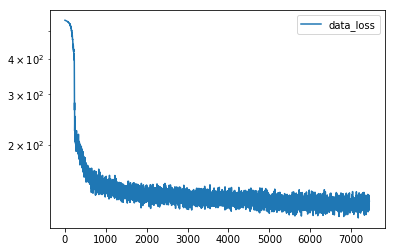

In [52]:
plot(losses_data,label='data_loss')
legend()
yscale('log')

In [0]:
res    = sess.run(z_samples, feed_dict={x: x_test[0:batch_size]})
labels = targets_test[0:batch_size]

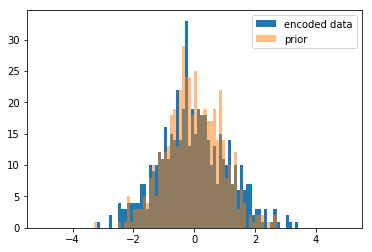

In [54]:
hist(res.flatten(),100,range=[-5,5],label='encoded data');
hist(randn(len(res.flatten())),100,range=[-5,5],alpha=0.5,label='prior');
legend()

<Figure size 360x360 with 0 Axes>

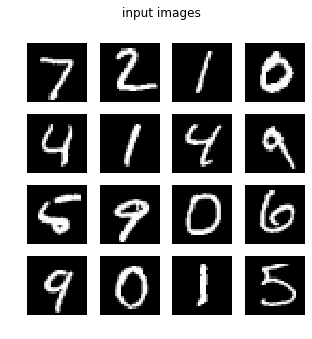

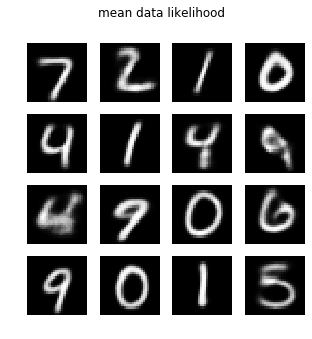

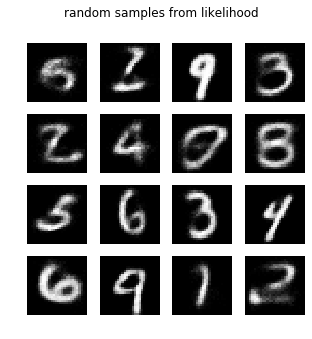

In [55]:
res, inim, s = sess.run([data_likelihood.mean(), x, x_sims], feed_dict={x: x_test[0:batch_size], sample_size: 100})
figure(figsize=(5,5))

    
figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow((res )[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('random samples from likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(s[:,i,:].reshape((-1,28,28)),axis=0),cmap='gray',vmin=0); #colorbar()
    axis('off')

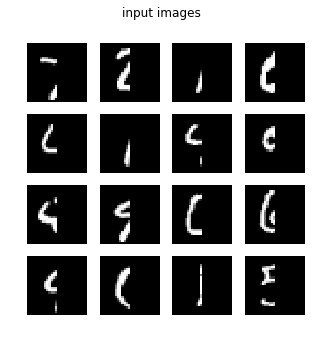

In [56]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[0:28,14:28]=0.
mask = mask.reshape((28*28))

masked_data = x_test[:batch_size2]*[mask]

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')

In [0]:
_ = sess.run(update1,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

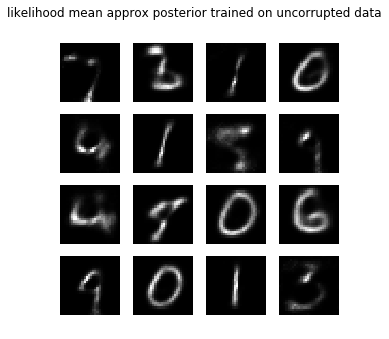

In [58]:
xrecons= sess.run(MAP_mean, feed_dict={x_corr: masked_data, x: masked_data, sample_size:100, mymask: mask})
xrecons.shape
    

figure(figsize=(5,5))
suptitle('likelihood mean approx posterior trained on uncorrupted data')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
      

In [0]:
posterior2_loss=[]

In [60]:
lrate=1e-1
for ii in range(20000):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    print(ll)

112.07469
47.539948
47.53784
47.539
47.53932
47.538895
47.539127
47.540905
47.539886
47.540123
47.539696
47.53943
47.538918
47.53999
47.54022
47.538982
47.53964
47.540733
47.54004
47.54002
47.540596
47.53916
47.54074
47.539894
47.53952
47.54002
47.541443
47.540848
47.540115
47.540806
47.540474
47.541245
47.54133
47.541103
47.542114
47.541832
47.54061
47.541515
47.541473
47.54296
47.541992
47.542305
47.54227
47.542175
47.543156
47.542225
47.542553
47.5432
47.542847
47.5431
47.542625
47.54413
47.543335
47.542877
47.542084
47.543
47.54464
47.545013
47.543625
47.544346
47.542667
47.54219
47.54352
47.541866


KeyboardInterrupt: ignored

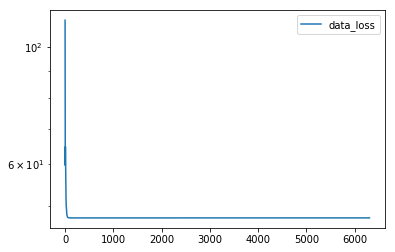

In [61]:
plot(posterior2_loss,label='data_loss')
legend()
yscale('log')

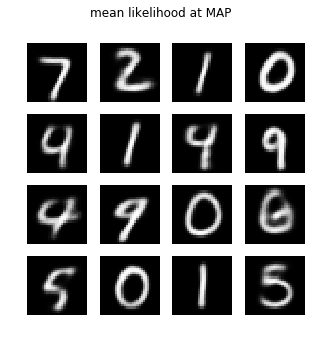

In [62]:
xrecons= sess.run(MAP_mean, feed_dict={x_corr: masked_data, x: masked_data, sample_size:100, mymask: mask})
xrecons.shape
    

figure(figsize=(5,5))
suptitle('mean likelihood at MAP')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')

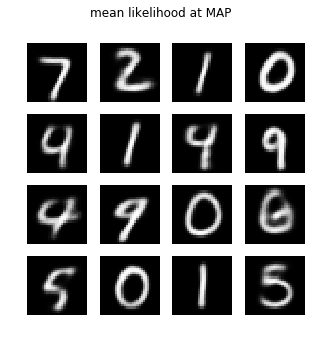

In [63]:
xrecons= sess.run(MAP_mean, feed_dict={x_corr: masked_data, x: masked_data, sample_size:100, mymask: mask})
xrecons.shape
    

figure(figsize=(5,5))
suptitle('mean likelihood at MAP')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')

In [0]:
_=sess.run(update2,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

In [0]:
_=sess.run(update3,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

(64, 64, 784)


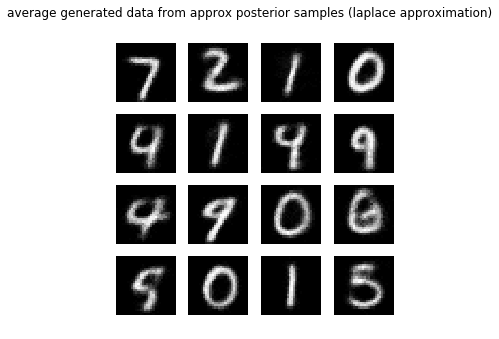

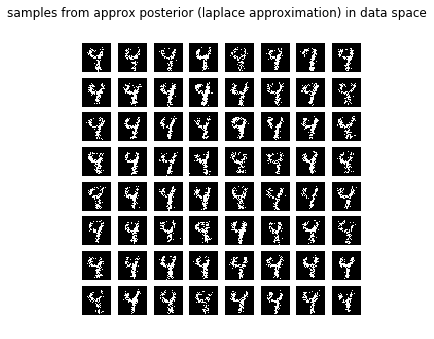

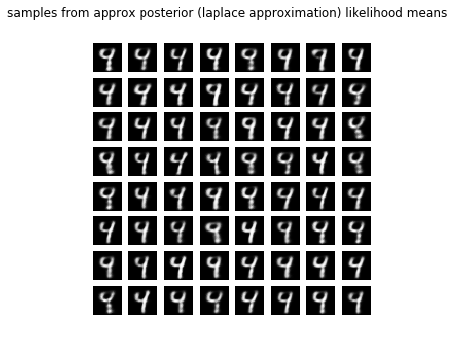

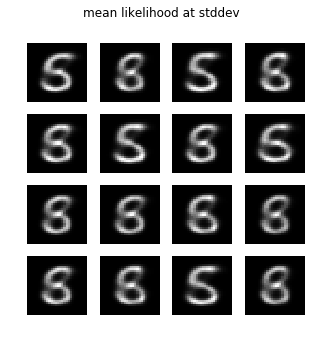

In [77]:
xrecons3, xrecons3b = sess.run([new_x_samples,new_x_mean], feed_dict={x_corr: masked_data, x: masked_data, sample_size:64, mymask: mask})

xrecons4 = sess.run(var_mean, feed_dict={x_corr: masked_data, x: masked_data, sample_size:64, mymask: mask})
print(xrecons3.shape)

figure(figsize=(5,5))
suptitle('average generated data from approx posterior samples (laplace approximation)')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(np.mean(xrecons3[:,i,:],axis=(0)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(np.mean(xrecons3[:,i,:],axis=(0)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
   
figure(figsize=(5,5))
suptitle('samples from approx posterior (laplace approximation) in data space')
for jj in range(64):   
  subplot(8,8,jj+1)
  imshow(xrecons3[jj,6,:].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
  axis('off')
  
figure(figsize=(5,5))
suptitle('samples from approx posterior (laplace approximation) likelihood means')
for jj in range(64):   
  subplot(8,8,jj+1)
  imshow(xrecons3b[jj,6,:].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
  axis('off')

      
figure(figsize=(5,5))
suptitle('mean likelihood at stddev')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(xrecons4[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(xrecons4[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
      

In [0]:
posterior3_loss=[]

In [79]:
lrate=1e-2
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo2, elbo2],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior3_loss.append(ll)
  if ii%100==0:
    print(ll)

150.83975
52.124565
51.255215
51.641994
50.936043
52.22365
51.501717
51.136456
50.84674
51.577282
51.18434
51.56144
51.326057
50.8665
51.397556
51.306545
51.46531
51.35698
51.215576
51.32943


(40, 64, 784)


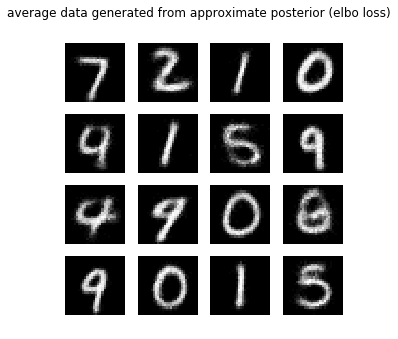

In [82]:
xrecons3= sess.run(x_samples_elbo, feed_dict={x_corr: masked_data, x: masked_data, sample_size:40, mymask: mask})
print(xrecons3.shape)
    

figure(figsize=(5,5))
suptitle('average data generated from approximate posterior (elbo loss)')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(np.mean(xrecons3[:,i,:],axis=(0)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(np.mean(xrecons3[:,i,:],axis=(0)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')